In [1]:
import sys
sys.path.append("../")

from functools import partial
from models.losses import sigmoid_loss, softmax_loss
from models.eval_utils import retrieval_eval_metric

%load_ext autoreload
%autoreload 2

In [2]:
from utils.dataset_utils import make_dataloader, create_input_iter

batch_size = 8

files = ['../data/tfrecords_v4/observations_train_1.tfrecord','../data/tfrecords_v4/observations_train_2.tfrecord',]
ds = make_dataloader(files, batch_size=batch_size, seed=42, caption_type="summary")
batches = create_input_iter(ds)

2023-12-23 10:57:23.968904: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-23 10:57:23.968960: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-23 10:57:23.970293: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import jax
from PIL import Image
import jax.numpy as np
import matplotlib.pyplot as plt

In [4]:
import optax 
from flax.training import checkpoints, common_utils, train_state
import flax

In [57]:
num_local_devices = jax.local_device_count()
num_local_devices

4

## Pre-trained

In [6]:
from transformers import FlaxCLIPModel, AutoProcessor

model = FlaxCLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [31]:
images, captions = next(iter(ds))
images = np.array(images)
captions = captions.numpy().tolist()
captions = [c.decode('utf-8') for c in captions]

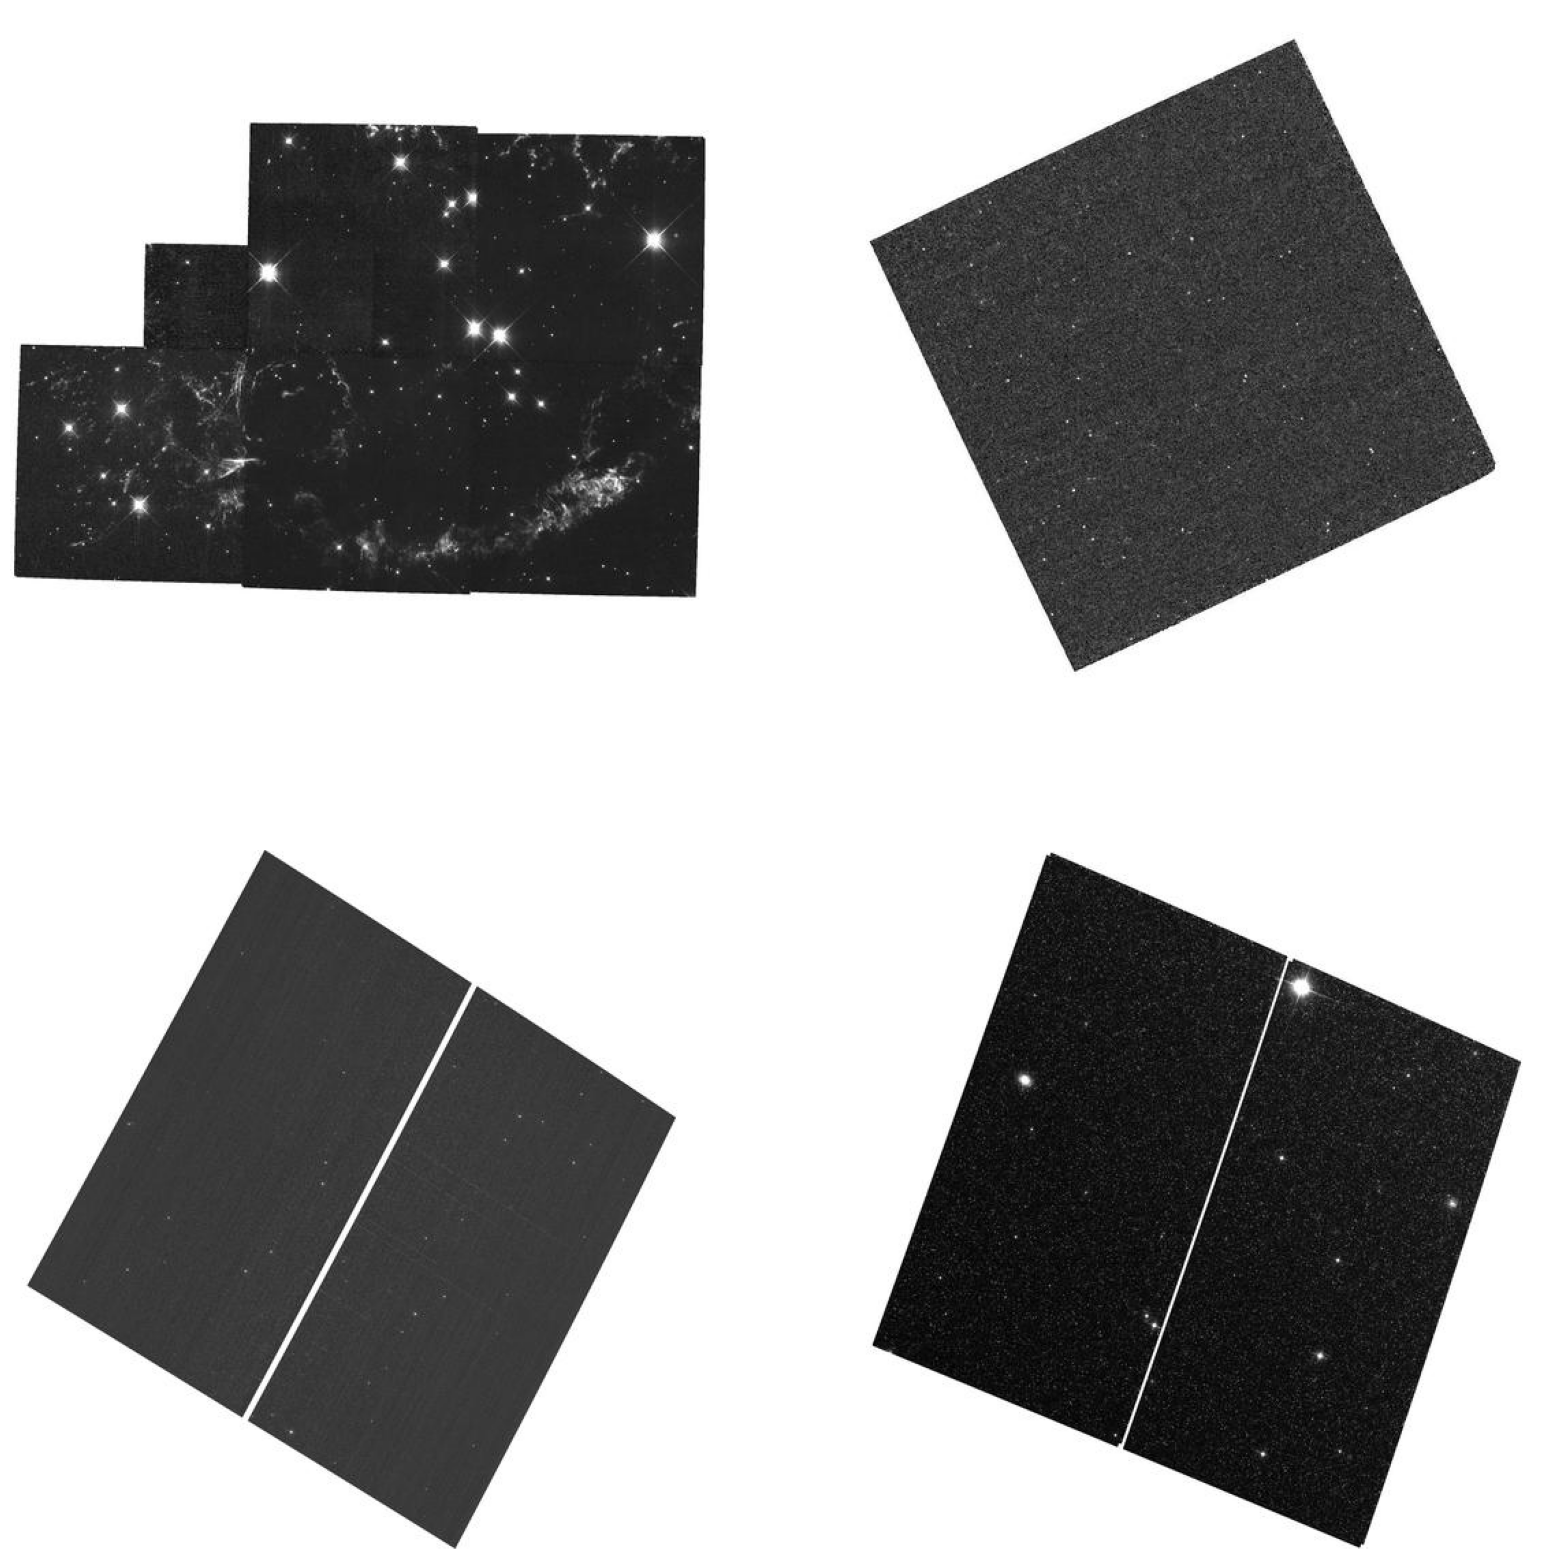

In [32]:
plt.figure(figsize=(20, 20))

grid_size = 2

# Loop through the images in the batch and plot them in a grid
for i in range(grid_size * grid_size):
    plt.subplot(grid_size, grid_size, i+1)
    plt.imshow(images[i], vmin=0, vmax=1)
    plt.axis('off')  # Turn off axis numbers and ticks

plt.show()

In [48]:
from dm_pix import random_crop, random_flip_up_down, random_flip_left_right, rotate
from functools import partial

# Rotate
rng_aug = jax.random.PRNGKey(46)
# rotation_angles = jax.random.choice(rng_aug, np.array([0, np.pi / 2, np.pi, 3 * np.pi / 2]), shape=(images.shape[0],))  # Angles in radians
# images = jax.vmap(partial(rotate, mode='constant', cval=1.))(images, rotation_angles)

# Flips
rng_aug, _ = jax.random.split(rng_aug)
images = jax.vmap(partial(random_flip_up_down, key=rng_aug))(image=images)

rng_aug, _ = jax.random.split(rng_aug)
images = jax.vmap(partial(random_flip_left_right, key=rng_aug))(image=images)

# Crop
rng_aug, _ = jax.random.split(rng_aug)
images = jax.vmap(random_crop, in_axes=(None,0,None))(rng_aug, images, (model.config.vision_config.image_size, model.config.vision_config.image_size, 3))

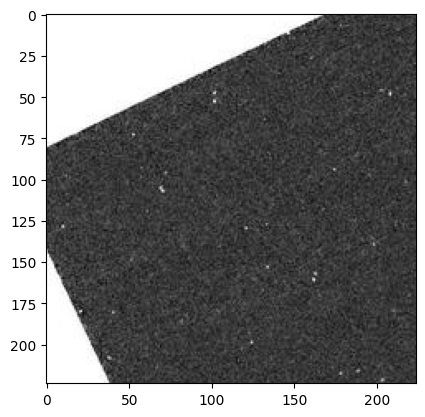

In [49]:
plt.imshow(images[1], vmin=0, vmax=1)

In [19]:
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32",)

In [20]:
inputs = processor(text=captions, images=(images * 255.), return_tensors="np", padding="max_length", truncation=True, max_length=model.config.text_config.max_length)

In [50]:
import nltk


def sample_and_pad(captions, key, max_length=77):
    sampled_seqs = []

    for caption in captions:
        sentences = nltk.sent_tokenize(caption)
        
        # If the total words are already less than or equal to max_length, just append the caption
        if len(caption.split()) <= max_length:
            sampled_seqs.append(caption)
            continue

        # Get random start index for sentences
        key, subkey = jax.random.split(key)
        start_idx = jax.random.randint(subkey, minval=0, maxval=len(sentences), shape=())

        # Rotate the sentences so that the starting sentence is at the beginning
        rotated_sentences = sentences[start_idx:] + sentences[:start_idx]

        sampled_words = []
        for sent in rotated_sentences:
            if len(sampled_words) + len(sent.split()) <= max_length:
                sampled_words.extend(sent.split())
            else:
                break

        sampled_seq = " ".join(sampled_words)
        sampled_seqs.append(sampled_seq)

    return sampled_seqs

In [51]:
key = jax.random.PRNGKey(47)
sample_and_pad(captions, key)

["Cassiopeia A (Cas A), supernova remnant, young, oxygen-rich, shock dynamics, ejecta, UV and optical line emission, metal-rich, reversed shock, CSM interaction, large ring-like structures, +/-6000 km s^-1 expansion velocity, sulfur, oxygen; small-scale spatial and ionization structures, metal-rich ejecta, reversed shock models, CSM-interaction models, high and low ionization emission lines of sulfur and oxygen, spatial information, ionization changes, structural changes, proper motions (0.2''-0.5'' yr^-1)",
 'extragalactic sources, near UV excesses (3000A), far UV sources (1600A), and galactic plane; discovering sources with excess ultraviolet flux, estimating colors of objects, and discriminating sources from cosmic rays',
 'stellar cluster members, PSF, focus, apparent coma, astigmatism, third order spherical changes in WFC3; monitoring the overall OTA focal length, focusing behavior, identifying focus dependencies, maintaining focus within science tolerances, determining focus offs

In [52]:
images *= 255

inputs = processor(
    text=captions, images=images, 
    return_tensors="np", 
    padding="max_length",
    truncation=True,
    max_length=77,
)

In [53]:
outputs = model(**inputs, params=model.params)

In [54]:
text_embeds = outputs["text_embeds"]
image_embeds = outputs["image_embeds"]

logits = np.matmul(text_embeds, image_embeds.T)

k = [1, 5, 10, 20]

# Compute the global top-k indices for the maximum k value
max_k = max(k)
top_k_indices = np.argsort(logits, axis=-1)[:, -max_k:]

correct_indices = np.arange(text_embeds.shape[0])[:, None]

metrics = {}
for current_k in k:
    # Check if the correct image (diagonal) is in the current top-k for each text embedding
    correct_in_top_k = np.any(top_k_indices[:, -current_k:] == correct_indices, axis=-1)
    accuracy = np.mean(correct_in_top_k.astype(np.float32))
    metrics[f"top_{current_k}_accuracy"] = accuracy

metrics

{'top_1_accuracy': Array(0.25, dtype=float32),
 'top_5_accuracy': Array(0.75, dtype=float32),
 'top_10_accuracy': Array(1., dtype=float32),
 'top_20_accuracy': Array(1., dtype=float32)}

In [56]:
from flax.core import FrozenDict

@partial(jax.pmap, axis_name="batch")
def train_step(state, input_ids, images, attention_mask):
    """Train for a single step."""

    def loss_fn(params):
        outputs = model(input_ids, images, attention_mask, params=params)
        outputs['logit_scale'] = model.params['logit_scale']
        outputs['logit_bias'] = model.params.get('logit_bias', 0.)
        
        loss = softmax_loss(outputs)
        # loss = sigmoid_loss(outputs)
        return loss

    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    grads = jax.lax.pmean(grads, "batch")
    new_state = state.apply_gradients(grads=grads)
    metrics = {"loss": jax.lax.pmean(loss, "batch")}
    return new_state, metrics


replicate = flax.jax_utils.replicate
unreplicate = flax.jax_utils.unreplicate

tx = optax.adamw(learning_rate=1e-4)
state = train_state.TrainState.create(
    apply_fn=model.__call__,
    params=FrozenDict(model.params) ,
    tx=tx,
)

pstate = replicate(state)

batch = jax.tree_map(lambda x: np.split(x, num_local_devices, axis=0), inputs.data)
new_pstate, metrics = train_step(pstate, np.array(batch["input_ids"]), np.array(batch["pixel_values"]), np.array(batch["attention_mask"]))

In [ ]:
metrics